In [ ]:
# Install SHAP if needed
%pip install shap -q

# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load dataset
df = pd.read_csv("data.csv")

# Add human-readable gender
df['Gender_Text'] = df['Gender'].map({1: 'Male', 0: 'Female'})

# Show basic info
print("Shape:", df.shape)
df.head()

Shape: (1500, 12)


,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision,Gender_Text
0,26,1,2,0,3,26.783828,48,78,91,1,1,Male
1,39,1,4,12,3,25.862694,35,68,80,2,1,Male
2,48,0,2,3,2,9.920805,20,67,13,2,0,Female
3,34,1,2,5,2,6.407751,36,27,70,3,0,Male
4,30,0,1,6,1,43.105343,23,52,85,2,0,Female


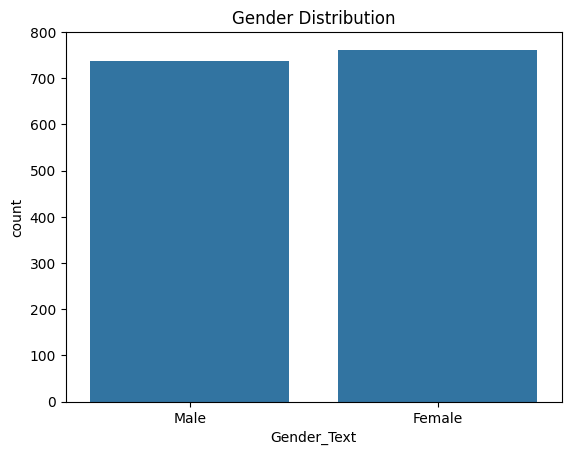

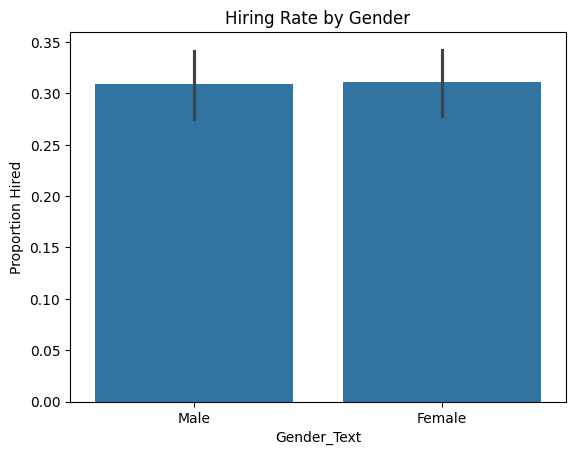

In [5]:
# Gender distribution
sns.countplot(data=df, x='Gender_Text')
plt.title("Gender Distribution")
plt.show()

# Hiring rate by gender
sns.barplot(x='Gender_Text', y='HiringDecision', data=df)
plt.title("Hiring Rate by Gender")
plt.ylabel("Proportion Hired")
plt.show()

In [6]:
# Drop target and sensitive
X = df.drop(['Gender', 'Gender_Text', 'HiringDecision'], axis=1)
y = df['HiringDecision']
gender = df['Gender_Text']

# Train/test split
X_train, X_test, y_train, y_test, gender_train, gender_test = train_test_split(
    X, y, gender,
    test_size=0.3,
    stratify=gender,
    random_state=42
)

In [7]:
model = LogisticRegression(max_iter=500, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Performance Report:")
print(classification_report(y_test, y_pred))

Performance Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       304
           1       0.84      0.70      0.76       146

    accuracy                           0.86       450
   macro avg       0.85      0.82      0.83       450
weighted avg       0.86      0.86      0.85       450



In [8]:
# Helper: get indexes
male_idx = gender_test == 'Male'
female_idx = gender_test == 'Female'

# Demographic Parity
dp_diff = abs(y_pred[male_idx].mean() - y_pred[female_idx].mean())
print("Demographic Parity Difference:", dp_diff)

# Equal Opportunity
tpr_male = ((y_pred == 1) & (y_test == 1) & male_idx).sum() / ((y_test == 1) & male_idx).sum()
tpr_female = ((y_pred == 1) & (y_test == 1) & female_idx).sum() / ((y_test == 1) & female_idx).sum()
eo_diff = abs(tpr_male - tpr_female)
print("Equal Opportunity Difference:", eo_diff)

# Average Odds
fpr_male = ((y_pred == 1) & (y_test == 0) & male_idx).sum() / ((y_test == 0) & male_idx).sum()
fpr_female = ((y_pred == 1) & (y_test == 0) & female_idx).sum() / ((y_test == 0) & female_idx).sum()
avg_odds_diff = (abs(fpr_male - fpr_female) + eo_diff) / 2
print("Average Odds Difference:", avg_odds_diff)

Demographic Parity Difference: 0.0007508545910805964
Equal Opportunity Difference: 0.07992424242424245
Average Odds Difference: 0.04524464989798396


/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


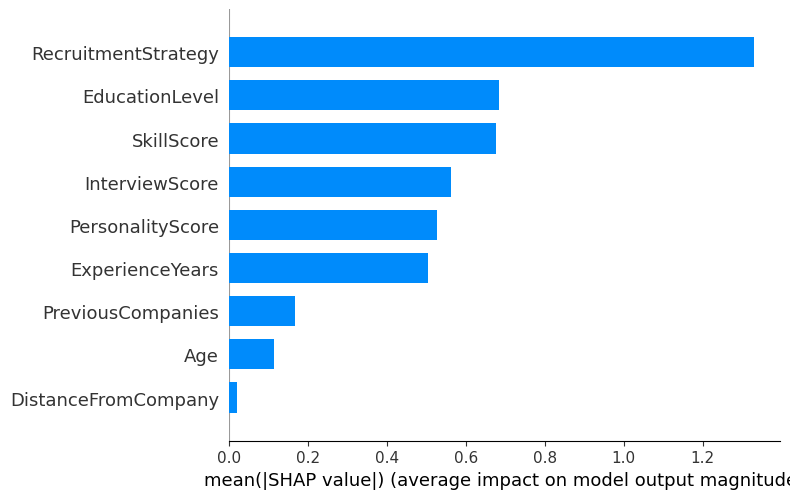

In [9]:
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

In [10]:
# Compute class weights
gender_counts = gender_train.value_counts(normalize=True)
weights_train = gender_train.map({
    'Male': 1 / gender_counts['Male'],
    'Female': 1 / gender_counts['Female']
})

# Fit new model
model_rw = LogisticRegression(max_iter=500, random_state=42)
model_rw.fit(X_train, y_train, sample_weight=weights_train)

# Predict and fairness check
y_pred_rw = model_rw.predict(X_test)
print("Reweighted Model Performance:")
print(classification_report(y_test, y_pred_rw))

# Re-run fairness metrics here...

Reweighted Model Performance:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       304
           1       0.84      0.70      0.76       146

    accuracy                           0.86       450
   macro avg       0.85      0.82      0.83       450
weighted avg       0.86      0.86      0.85       450

